# TP2 - DB Normalization and Querying

The objectives of this TP are:
1. Apply normalization 1NF -> 2NF -> 3NF
2. Perform SQL queries on the normalized database

In this TP, we will use a database **`wine.db`** (available in the course's website) containing wine information related to 'production' and 'sales'. 

> Production <---> Wine <---> Sales


---

### Working with db files in Jupyter
- Python provides an interface for SQLite through the *sqlite3* module
- The **`%%sql`** magic builds upon it (and other tools) to enable the usage of SQL commands within a Jupyter Notebook as in common SQL clients.
- Before proceeding, make sure that **`wine.db`** is in the same path as this notebook.
  - If **`wine.db`** is not in the same path, an empty **`wine.db`** file will be created, resulting in errors in later steps of the TP.
- The SQLite module in Python commits transactions automatically, this means that any change in the DB is immediately written to the file, e.g. creating/deleting tables.
  -  For this reason, it is recommended to have a backup of **`wine.db`** as it is provided in the course's website.

---

**`wine.db`** contains the following unnormalized tables:

<center>**Master1**</center>

|*Attribute*|         *Description*          |
| -------   |--------------------------------|
| NV        | Wine number                    |
| CRU       | Vineyard or group of vineyards |
| DEGRE     | Alcohol content                |
| MILL      | Vintage year                   |
| QTE       | Number of bottles harvested    |
| NP        | Producer number                |
| NOM       | Producer's last name           |
| PRENOM    | Producer's first name          |
| REGION    | Production region              |

From wikipedia:

__Cru__: Often used to indicate a specifically named and legally defined vineyard or ensemble of vineyards and the vines "which grow on [such] a reputed terroir; by extension of good quality." The term is also used to refer to the wine produced from such vines.


<center>**Master2**</center>

|*Attribute*|                         *Description*                  |
| -------   |--------------------------------------------------------|
| NV        | Wine number                                            |
| CRU       | Vineyard or group of vineyards                         |
| DEGRE     | Alcohol content                                        |
| MILL      | Vintage year                                           |
| DATES     | Buying date                                            |
| LIEU      | Place where the wine was sold                          |
| QTE       | Number of bottles bought                               |
| NB        | Client (buveur) number                                 |
| NOM       | Client's last name                                     |
| PRENOM    | Client's first name                                    |
| TYPE      | Type of client by volume of purchases                  |
| REGION    | Administrative Region (different to production region) |


In [1]:
import sqlite3    # Python interface for SQLite databases

In [2]:
def printSchema(connection):
    # Function to print the DB schema
    # Source: http://stackoverflow.com/a/35092773/4765776
    for (tableName,) in connection.execute(
        """
        select NAME from SQLITE_MASTER where TYPE='table' order by NAME;
        """
    ):
        print("{}:".format(tableName))
        for (
            columnID, columnName, columnType,
            columnNotNull, columnDefault, columnPK,
        ) in connection.execute("pragma table_info('{}');".format(tableName)):
            print("  {id}: {name}({type}){null}{default}{pk}".format(
                id=columnID,
                name=columnName,
                type=columnType,
                null=" not null" if columnNotNull else "",
                default=" [{}]".format(columnDefault) if columnDefault else "",
                pk=" *{}".format(columnPK) if columnPK else "",
            ))

In [3]:
conn = sqlite3.connect('wine.db')
c = conn.cursor()
print("Database schema:")
printSchema(conn)           # An usefull way to viualize the content of the database

Database schema:
MASTER1:
  0: NV(NUM)
  1: CRU(TEXT)
  2: DEGRE(NUM)
  3: MILL(NUM)
  4: QTE(NUM)
  5: NP(NUM)
  6: NOM(TEXT)
  7: PRENOM(TEXT)
  8: REGION(TEXT)
MASTER2:
  0: NV(NUM)
  1: CRU(TEXT)
  2: DEGRE(NUM)
  3: MILL(NUM)
  4: DATES(DATE)
  5: LIEU(TEXT)
  6: QTE(NUM)
  7: NB(NUM)
  8: NOM(TEXT)
  9: PRENOM(TEXT)
  10: TYPE(TEXT)
  11: REGION(TEXT)
buyer:
  0: NB(NUM)
  1: NOM(TEXT)
  2: PRENOM(TEXT)
  3: TYPE(TEXT)
dummy:
  0: DEGRE(NUM)
lieu:
  0: LIEU(TEXT)
  1: REGION(TEXT)
producer:
  0: NP(NUM)
  1: NOM(TEXT)
  2: PRENOM(TEXT)
  3: REGION(TEXT)
quantityBought:
  0: NV(NUM)
  1: NB(NUM)
  2: DATES(NUM)
  3: LIEU(TEXT)
  4: QTE(NUM)
quantitySold:
  0: NV(NUM)
  1: NP(NUM)
  2: QTE(NUM)
wineB:
  0: NV(NUM)
  1: CRU(TEXT)
  2: DEGRE(NUM)
  3: MILL(NUM)
wineS:
  0: NV(NUM)
  1: CRU(TEXT)
  2: DEGRE(NUM)
  3: MILL(NUM)


From this point we will use __%%sql__ magic

In [4]:
%load_ext sql
%sql sqlite:///wine.db

# PART I: Database normalization

The first task on this TP is the normalization of the wine data. In its current state both tables **Master1** and **Master2** are in the First Normal Form (1NF).

By inspecting the content of these tables we can see that multiple tuples have NULL values.

In [5]:
%%sql SELECT *
FROM Master1
LIMIT 10;

 * sqlite:///wine.db
Done.


NV,CRU,DEGRE,MILL,QTE,NP,NOM,PRENOM,REGION
None,None,None,None,None,3,Six,Paul,Alsace
None,None,None,None,None,6,Marmagne,Bernard,Bourgogne
None,None,None,None,None,8,Lioger d'Harduy,Gabriel,Bourgogne
None,None,None,None,None,16,Barbin,Bernard,Bourgogne
None,None,None,None,None,17,Faiveley,Guy,Bourgogne
None,None,None,None,None,18,Tramier,Jean,Bourgogne
None,None,None,None,None,19,Dupaquier,Roger,Bourgogne
None,None,None,None,None,20,Lamy,Jean,Bourgogne
None,None,None,None,None,21,Cornu,Edmond,Bourgogne
None,None,None,None,None,26,Violot,Gilbert,Bourgogne


* Notice that Jupyter *displays* 'None' instead of 'NULL'. 
  - This is only to comply with python notation.
* To account for NULL values, your SQL queries must test explicitly for 'NULL'.

Another problem in **Master1** and **Master2** is data redundancy, for example:

In [6]:
%%sql SELECT *
FROM Master1
WHERE NV = 45;

 * sqlite:///wine.db
Done.


NV,CRU,DEGRE,MILL,QTE,NP,NOM,PRENOM,REGION
45,Chiroubles,None,1983,90,2,Boxler,Albert,Alsace
45,Chiroubles,None,1983,912,67,Descombes,Jean Ernest,Beaujolais
45,Chiroubles,None,1983,98,71,Chalandard,Danile,Jura
45,Chiroubles,None,1983,540,78,Michlel,Pierre Emile,Jura
45,Chiroubles,None,1983,450,86,Dumazet,Marc,Rhone


---

Additional resource for Normalization:

https://www.youtube.com/watch?v=UrYLYV7WSHM

---

#### Exercise 1.1

Convert table **Master1** to the Second Normal Form (2NF) or Third Normal Form (3NF) as applicable.
* Explain your answer
* List main functional dependencies (not all of them)
* Describe the schema of new tables and how they relate
  * You can write Tables as above or you can insert images in the notebook.
  
Remember that **`wine.db`** contains information related to wine 'production' and 'sells'.

> Production <---> Wine <---> Sales

A good start point is to look for the 'Wine' attributes.

**Hint:** Look for redundant information between the master tables.

The key for Master1 is {NV, NP}. We have {NV} -> {CRU, DEGRE, MIL}, {NP} -> {NOM, PRENOM, REGION} and {NV, NP} -> {QTE} as the main functional dependencies. This is in 1NF but not in 2NF as we have attributes that does not depend on the primary key. Hence, we can separate the tables into 3. This completes the 2NF.

Example of table:\
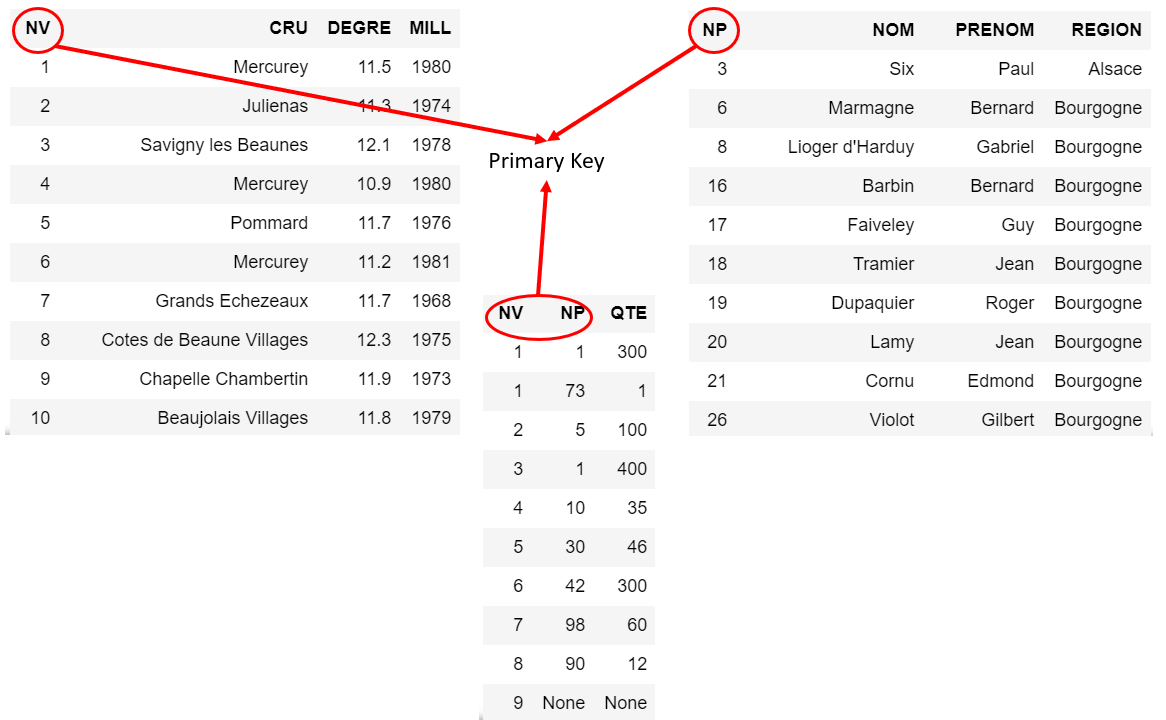\
We see that all columns in each table depends uniquely on the primary key of their respective table, hence this is also the 3NF.

In [7]:
%%sql SELECT DISTINCT LIEU, REGION
from MASTER2
where LIEU IS NOT NULL;

 * sqlite:///wine.db
Done.


LIEU,REGION
BORDEAUX,NOUVELLE-AQUITAINE
PARIS,ÎLE-DE-FRANCE
RENNES,BRETAGNE
LYON,AUVERGNE-RHÔNE-ALPES
NICE,PROVENCE-ALPES-CÔTE D'AZUR
MERCUREY,BOURGOGNE-FRANCHE-COMTÉ
TOULOUSE,OCCITANIE
SENS,BOURGOGNE-FRANCHE-COMTÉ
LILLE,HAUTS-DE-FRANCE
NANCY,GRAND EST


#### Exercise 1.2

Convert table **Master2** to the Second Normal Form (2NF) or Third Normal Form (3NF) as applicable.
* Explain your answer
* List main functional dependencies (not all of them)
* Describe the schema of new tables and how they relate
  * You can write Tables as above or you can insert images in the notebook.

**Note:** For this part, consider that a wine can be bought in multiple locations and multiple times per day.

The key for Master2 is {NV, NP}. We have {NV} -> {CRU, DEGRE, MIL}, {NP} -> {NOM, PRENOM, TYPE} and {NV, NP} -> {DATES, LIEU, REGION, QTE} as the main functional dependencies. This is in 1NF but not in 2NF as we have attributes that does not depend on the primary key. Hence, we can separate the tables into 3. This completes the 2NF.

Example of table:\
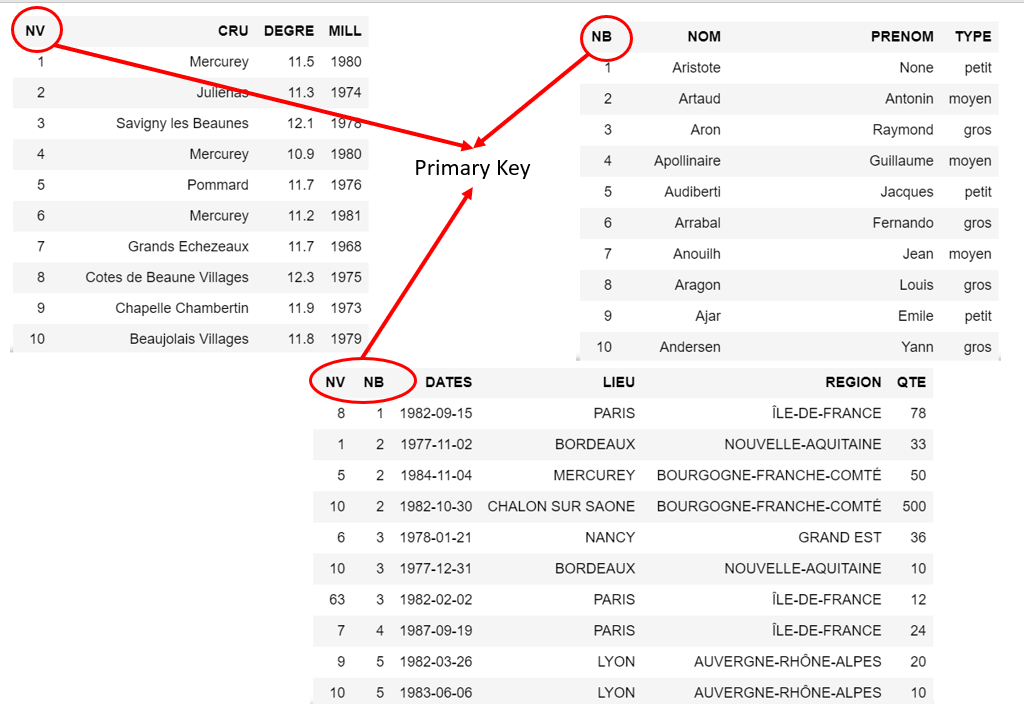\
However, we observe that in the NB, NV table that REGION can also depend on LIEU. This is not in 3NF. We extract REGION from this table to form another table to achieve 3NF.

Example of table:\
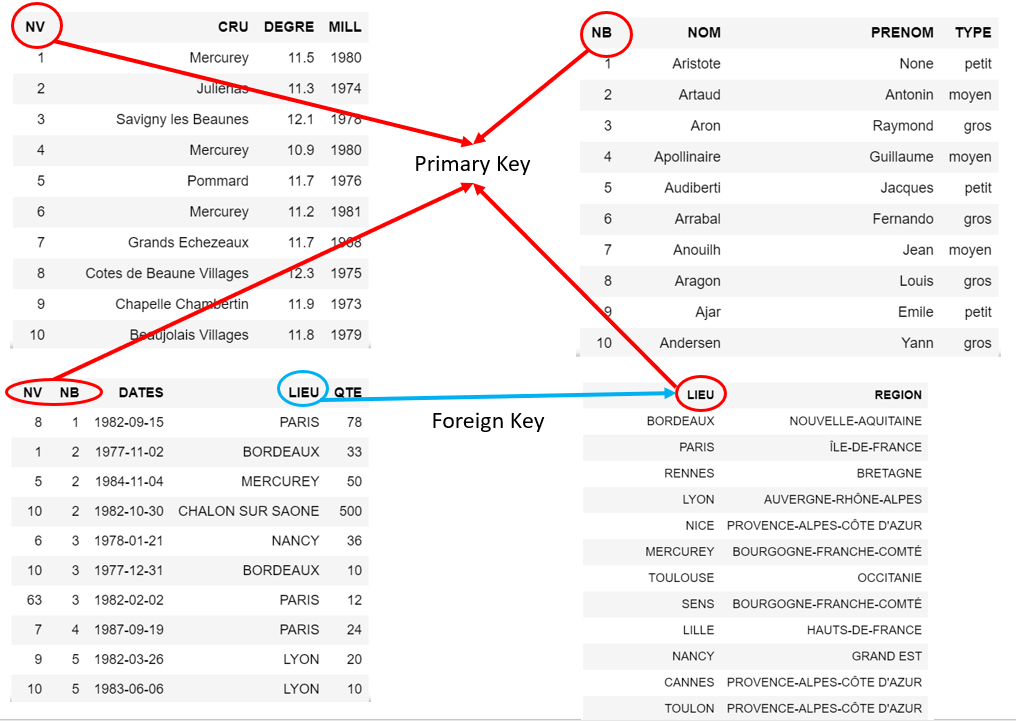

Once you have defined the 2NF or 3NF (as applicable) we need to split the data into new tables.

A table can be created from the result of a query.

In the following example we will create a new table "dummy" to store the different values of alcohol content.

In [8]:
%%sql DROP TABLE IF EXISTS dummy;

-- Create dummy table
CREATE TABLE dummy AS
SELECT DISTINCT DEGRE
FROM MASTER1;

 * sqlite:///wine.db
Done.
Done.


[]

In [9]:
print("\nContent of the database")
printSchema(conn)


Content of the database
MASTER1:
  0: NV(NUM)
  1: CRU(TEXT)
  2: DEGRE(NUM)
  3: MILL(NUM)
  4: QTE(NUM)
  5: NP(NUM)
  6: NOM(TEXT)
  7: PRENOM(TEXT)
  8: REGION(TEXT)
MASTER2:
  0: NV(NUM)
  1: CRU(TEXT)
  2: DEGRE(NUM)
  3: MILL(NUM)
  4: DATES(DATE)
  5: LIEU(TEXT)
  6: QTE(NUM)
  7: NB(NUM)
  8: NOM(TEXT)
  9: PRENOM(TEXT)
  10: TYPE(TEXT)
  11: REGION(TEXT)
buyer:
  0: NB(NUM)
  1: NOM(TEXT)
  2: PRENOM(TEXT)
  3: TYPE(TEXT)
dummy:
  0: DEGRE(NUM)
lieu:
  0: LIEU(TEXT)
  1: REGION(TEXT)
producer:
  0: NP(NUM)
  1: NOM(TEXT)
  2: PRENOM(TEXT)
  3: REGION(TEXT)
quantityBought:
  0: NV(NUM)
  1: NB(NUM)
  2: DATES(NUM)
  3: LIEU(TEXT)
  4: QTE(NUM)
quantitySold:
  0: NV(NUM)
  1: NP(NUM)
  2: QTE(NUM)
wineB:
  0: NV(NUM)
  1: CRU(TEXT)
  2: DEGRE(NUM)
  3: MILL(NUM)
wineS:
  0: NV(NUM)
  1: CRU(TEXT)
  2: DEGRE(NUM)
  3: MILL(NUM)


In [10]:
%%sql
SELECT *
FROM dummy;

 * sqlite:///wine.db
Done.


DEGRE
None
11.5
11.3
12.1
10.9
11.7
11.2
12.3
11.9
11.8


Looking into "dummy", we notice that our query includes NULL. This is not allowed if we were to use DEGRE as key for a table.

To correct this, we need to change the query to explicitly test for NULL as follows:

In [11]:
%%sql DROP TABLE IF EXISTS dummy;

-- Create dummy table
CREATE TABLE dummy AS
SELECT DISTINCT DEGRE
FROM MASTER1
WHERE DEGRE IS NOT NULL;

SELECT *
FROM dummy;

 * sqlite:///wine.db
Done.
Done.
Done.


DEGRE
11.5
11.3
12.1
10.9
11.7
11.2
12.3
11.9
11.8
10.7


Notice that we use `NULL` given that `None` is only used for display.

In [12]:
# Remove "dummy" table
%sql DROP TABLE IF EXISTS dummy;

 * sqlite:///wine.db
Done.


[]

#### Exercise 1.3

Create the new tables from Master1:

In [13]:
%%sql DROP TABLE IF EXISTS wine;

-- Create wineS table
CREATE TABLE wineS AS
SELECT DISTINCT NV, CRU, DEGRE, MILL
FROM MASTER1
WHERE NV IS NOT NULL
ORDER BY NV;

DROP TABLE IF EXISTS producer;

-- Create producer table
CREATE TABLE producer AS
SELECT DISTINCT NP, NOM, PRENOM, REGION
FROM MASTER1
WHERE NP IS NOT NULL
ORDER BY NP;

DROP TABLE IF EXISTS quantitySold;

-- Create quantitySold table
CREATE TABLE quantitySold AS
SELECT DISTINCT NV, NP, QTE
FROM MASTER1
WHERE NP IS NOT NULL
ORDER BY NV, NP;

 * sqlite:///wine.db
Done.
(sqlite3.OperationalError) table wineS already exists
[SQL: -- Create wineS table
CREATE TABLE wineS AS
SELECT DISTINCT NV, CRU, DEGRE, MILL
FROM MASTER1
WHERE NV IS NOT NULL
ORDER BY NV;]
(Background on this error at: http://sqlalche.me/e/13/e3q8)


#### Exercise 1.4

Create the new tables from Master2:

In [14]:
%%sql DROP TABLE IF EXISTS wineB;

-- Create wineB table
CREATE TABLE wineB AS
SELECT DISTINCT NV, CRU, DEGRE, MILL
FROM MASTER2
WHERE NV IS NOT NULL
ORDER BY NV;

DROP TABLE IF EXISTS buyer;

-- Create buyer table
CREATE TABLE buyer AS
SELECT DISTINCT NB, NOM, PRENOM, TYPE
FROM MASTER2
WHERE NB IS NOT NULL
ORDER BY NB;

DROP TABLE IF EXISTS lieu;

-- Create lieu table
CREATE TABLE lieu AS
SELECT DISTINCT LIEU, REGION
FROM MASTER2
WHERE LIEU IS NOT NULL
ORDER BY LIEU;

DROP TABLE IF EXISTS quantityBought;

-- Create quantityBought table
CREATE TABLE quantityBought AS
SELECT DISTINCT NV, NB, DATES, LIEU, QTE
FROM MASTER2
WHERE NB IS NOT NULL
ORDER BY NV, NB;

 * sqlite:///wine.db
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.


[]

# PART II: SQL QUERIES

In the second part of this TP you will create SQL queries to retrieve information from the database.

**Important:**

- You MUST use the normalized tables created in previous steps.
  - The normalized tables will also be used in TP3.
- Do NOT use **Master1** and **Master2** in your queries.

#### Exercise 2.1

What are the different types of clients (buveurs) by volume of purchases?

In [15]:
%%sql SELECT DISTINCT TYPE AS Type_of_buveurs
FROM buyer;

 * sqlite:///wine.db
Done.


Type_of_buveurs
petit
moyen
gros


#### Exercise 2.2

What regions produce Pommard or Brouilly?

In [16]:
%%sql SELECT DISTINCT wineS.CRU, producer.REGION
FROM wineS, producer, quantitySold
WHERE (quantitySold.NV = wineS.NV AND quantitySold.NP = producer.NP)
AND (CRU = "Pommard" OR CRU = "Brouilly")

 * sqlite:///wine.db
Done.


CRU,REGION
Pommard,Bourgogne
Pommard,Rhone
Brouilly,Bourgogne


#### Exercise 2.3

What regions produce Pommard and Brouilly?

In [17]:
%%sql 
SELECT REGION
FROM wineS, producer, quantitySold
WHERE wineS.NV = quantitySold.NV AND producer.NP = quantitySold.NP
AND (CRU = "Pommard")

INTERSECT

SELECT REGION
FROM wineS, producer, quantitySold
WHERE wineS.NV = quantitySold.NV AND producer.NP = quantitySold.NP
AND (CRU = "Brouilly")

 * sqlite:///wine.db
Done.


REGION
Bourgogne


#### Exercise 2.4

Get the number of wines bought by CRU and Millésime

In [18]:
%%sql SELECT CRU, MILL, SUM(QTE) AS Number_of_wines_bought
FROM wineS, quantityBought
WHERE wineS.NV = quantityBought.NV
GROUP BY CRU, MILL
ORDER BY CRU ASC, MILL DESC;

 * sqlite:///wine.db
Done.


CRU,MILL,Number_of_wines_bought
Arbois,1980,8
Auxey Duresses,1914,80
Beaujolais Primeur,1983,7
Beaujolais Villages,1979,520
Beaujolais Villages,1978,130
Beaujolais Villages,1976,120
Beaujolais Villages,1975,10
Chapelle Chambertin,1973,30
Chateau Corton Grancey,1980,4
Chenas,1984,1


#### Exercise 2.5

Retrieve the wine number (NV) of wines produced by more than three producers

In [19]:
%%sql SELECT NV, COUNT(NV) AS Number_of_producers
FROM quantitySold
GROUP BY NV
HAVING COUNT(NV) > 3;

 * sqlite:///wine.db
Done.


NV,Number_of_producers
45,5
78,5
89,4
98,5


#### Exercise 2.6

Which producers have not produced any wine?

In [20]:
%%sql SELECT quantitySold.NP, NOM, PRENOM
FROM quantitySold, producer
WHERE quantitySold.NP = producer.NP
GROUP BY quantitySold.NP
HAVING SUM(QTE) IS NULL;

 * sqlite:///wine.db
Done.


NP,NOM,PRENOM
3,Six,Paul
6,Marmagne,Bernard
8,Lioger d'Harduy,Gabriel
16,Barbin,Bernard
17,Faiveley,Guy
18,Tramier,Jean
19,Dupaquier,Roger
20,Lamy,Jean
21,Cornu,Edmond
26,Violot,Gilbert


#### Exercise 2.7

What clients (buveurs) have bought at least one wine from 1980?

In [21]:
%%sql SELECT buyer.NB, NOM, PRENOM
FROM wineB, buyer, quantityBought
WHERE buyer.NB = quantityBought.NB
AND wineB.NV = quantityBought.NV
AND wineB.MILL = 1980
GROUP BY buyer.NB;

 * sqlite:///wine.db
Done.


NB,NOM,PRENOM
2,Artaud,Antonin
8,Aragon,Louis
44,Gide,Andre
45,Giono,Jean
50,Lautreamont,None
61,Mallarme,Stephane


#### Exercise 2.8

What clients (buveurs) have NOT bought any wine from 1980?

In [22]:
%%sql SELECT buyer.NB, NOM, PRENOM
FROM wineB, buyer, quantityBought
WHERE buyer.NB = quantityBought.NB
AND wineB.NV = quantityBought.NV
GROUP BY buyer.NB

EXCEPT

SELECT buyer.NB, NOM, PRENOM
FROM wineB, buyer, quantityBought
WHERE buyer.NB = quantityBought.NB
AND wineB.NV = quantityBought.NV
AND wineB.MILL = 1980
GROUP BY buyer.NB

UNION

SELECT buyer.NB, NOM, PRENOM
FROM wineB, buyer, quantityBought
WHERE buyer.NB = quantityBought.NB
AND quantityBought.NV IS NULL;

 * sqlite:///wine.db
Done.


NB,NOM,PRENOM
1,Aristote,None
3,Aron,Raymond
4,Apollinaire,Guillaume
5,Audiberti,Jacques
6,Arrabal,Fernando
7,Anouilh,Jean
9,Ajar,Emile
10,Andersen,Yann
11,Breton,Andre
12,Bataille,Georges


#### Exercise 2.9

What clients (buveurs) have bought ONLY wines from 1980?

In [23]:
%%sql SELECT buyer.NB, NOM, PRENOM
FROM wineB, buyer, quantityBought
WHERE buyer.NB = quantityBought.NB
AND wineB.NV = quantityBought.NV
AND wineB.MILL = 1980
GROUP BY buyer.NB

EXCEPT

SELECT buyer.NB, NOM, PRENOM
FROM wineB, buyer, quantityBought
WHERE buyer.NB = quantityBought.NB
AND wineB.NV = quantityBought.NV
AND wineB.MILL != 1980
GROUP BY buyer.NB

 * sqlite:///wine.db
Done.


NB,NOM,PRENOM
44,Gide,Andre
45,Giono,Jean
50,Lautreamont,None


#### Exercise 2.10

List all wines from 1980

In [24]:
%%sql SELECT *
FROM wineB
WHERE MILL = 1980

 * sqlite:///wine.db
Done.


NV,CRU,DEGRE,MILL
1,Mercurey,11.5,1980
4,Mercurey,10.9,1980
16,Meursault,12.1,1980
20,Cote de Brouilly,12.1,1980
26,Chateau Corton Grancey,None,1980
28,Volnay,11,1980
43,Fleurie,11.4,1980
74,Arbois,12,1980
78,Etoile,12,1980
79,Seyssel,11,1980


#### Exercise 2.11

What are the wines from 1980 bought by NB=2?

In [25]:
%%sql SELECT wineB.NV, CRU, MILL, DEGRE
FROM wineB, quantityBought
WHERE MILL = 1980
AND wineB.NV = quantityBought.NV
AND quantityBought.NB = 2;

 * sqlite:///wine.db
Done.


NV,CRU,MILL,DEGRE
1,Mercurey,1980,11.5


#### Exercise 2.12

What clients (buveurs) have bought ALL the wines from 1980?

In [26]:
%%sql SELECT buyer.NB, NOM, PRENOM
FROM buyer
WHERE NOT EXISTS (SELECT wineB.NV
                  FROM wineB
                  WHERE MILL = 1980
                  AND NOT EXISTS (SELECT quantityBought.NB
                                    FROM quantityBought
                                    WHERE quantityBought.NV = wineB.NV
                                    AND quantityBought.NB = buyer.NB
                                   )
                );

 * sqlite:///wine.db
Done.


NB,NOM,PRENOM
44,Gide,Andre
